<a href="https://colab.research.google.com/github/therealcs1010/CS4248-Project/blob/main/Fatin/Fatin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data and Preprocess**

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess(text, string=True):
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if not w in set(stopwords.words("english"))]
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    if string:
        return " ".join(words)
    else:
        return words

In [ ]:
def get_data(file):
    data = pd.read_json(file)
    x_data = data['text'].apply(preprocess)
    y_data = data['label']
    return x_data, y_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [ ]:
x_train, y_train = get_data('/content/drive/MyDrive/train.json')
x_test, y_test = get_data('/content/drive/MyDrive/test.json')

In [ ]:
x_train.to_csv('data/x_train.csv')
x_test.to_csv('data/x_test.csv')
x_train = pd.read_csv('/content/drive/MyDrive/x_train.csv', index_col=False, header=0)['text']
x_test = pd.read_csv('/content/drive/MyDrive/x_test.csv', index_col=False, header=0)['text']
x_train

0        bromwell high cartoon comedy ran time program ...
1        homelessness houselessness george carlin state...
2        brilliant overacting lesley ann warren best dr...
3        easily underrated film inn brook cannon sure f...
4        typical mel brook film much le slapstick movie...
                               ...                        
24995    towards end movie felt technical felt like cla...
24996    kind movie enemy content watch time bloody tru...
24997    saw descent last night stockholm film festival...
24998    film pick pound turn rather good 23rd century ...
24999    one dumbest film ive ever seen rip nearly ever...
Name: text, Length: 25000, dtype: object

In [ ]:
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/y_train.csv', index_col=False, header=0)['label']
y_test = pd.read_csv('/content/drive/MyDrive/y_test.csv', index_col=False, header=0)['label']
y_train.unique()

array(['+', '-'], dtype=object)

In [ ]:
mapping = {'+': 1, '-': -1}
train_sentiment = y_train.replace(mapping)
test_sentiment = y_test.replace(mapping)
train_sentiment

0        1
1        1
2        1
3        1
4        1
        ..
24995   -1
24996   -1
24997   -1
24998   -1
24999   -1
Name: label, Length: 25000, dtype: int64

# **Feature Engineering with BoW and Tf-idf**

In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
def get_bow(clean_train_text, clean_test_text):
    vectorizer = CountVectorizer(analyzer = "word", max_features = 10000) 
    train_bow = vectorizer.fit_transform(clean_train_text).toarray()
    test_bow = vectorizer.transform(clean_test_text).toarray()
    return train_bow, test_bow

In [ ]:
def get_tfidf(train_bow, test_bow):
    tfidf_transformer = TfidfTransformer().fit(train_bow)
    train_tfidf = tfidf_transformer.transform(train_bow)
    test_tfidf = tfidf_transformer.transform(test_bow)
    return train_tfidf, test_tfidf

In [ ]:
train_bow, test_bow = get_bow(x_train.tolist(), x_test.tolist())
train_tfidf, test_tfidf = get_tfidf(train_bow, test_bow)
train_tfidf

<25000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2189419 stored elements in Compressed Sparse Row format>

# **Feature Engineering with Word2Vec**

In [ ]:
nltk.download('punkt')   
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def get_sentences( review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            words = preprocess(raw_sentence, string=False)
            sentences.append(words)
    return sentences

In [ ]:
data = pd.read_json('/content/drive/MyDrive/train.json')
raw_x_train = data['text']
raw_y_train = data['label']
data = pd.read_json('/content/drive/MyDrive/test.json')
raw_x_test = data['text']
raw_y_test = data['label']

In [ ]:
sentences = []
for review in raw_x_train:
    sentences += get_sentences(review, tokenizer)
sentences[0]

['bromwell', 'high', 'cartoon', 'comedy']

In [ ]:
# df = pd.DataFrame(np.array(sentences))
# df.reset_index().to_json('/content/drive/MyDrive/sentences.json')
data_sentences = pd.read_json('/content/drive/MyDrive/sentences.json')
sentences = data_sentences['0']
sentences

0                         [bromwell, high, cartoon, comedy]
1               [ran, time, program, school, life, teacher]
2         [35, year, teaching, profession, lead, believe...
3         [scramble, survive, financially, insightful, s...
4         [saw, episode, student, repeatedly, tried, bur...
                                ...                        
270848                [one, dumbest, film, ive, ever, seen]
270849    [rip, nearly, ever, type, thriller, manages, m...
270850    [plot, afterthought, far, acting, go, there, n...
270851    [honestly, cant, understand, type, nonsense, g...
270852    [crap, like, people, downloading, illegally, t...
Name: 0, Length: 270853, dtype: object

In [ ]:
from gensim.models import Word2Vec
import numpy as np

In [ ]:
vector_size = 500
model = Word2Vec(sentences=sentences, size=vector_size, window=10, min_count=1, workers=4)
model.init_sims(replace=True)

In [ ]:
def makeFeatureVec(words, model, num_features):
    '''Average all of the word vectors in a paragraph'''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [ ]:
def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Given a set of reviews (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
clean_train_reviews = raw_x_train.apply(preprocess, string=False)
clean_test_reviews = raw_x_test.apply(preprocess, string=False)
clean_train_reviews

0        [went, saw, movie, last, night, coaxed, friend...
1        [actor, turned, director, bill, paxton, follow...
2        [recreational, golfer, knowledge, sport, histo...
3        [saw, film, sneak, preview, delightful, cinema...
4        [bill, paxton, taken, true, story, 1913, u, go...
                               ...                        
24995    [occasionally, let, kid, watch, garbage, under...
24996    [anymore, pretty, much, reality, tv, show, peo...
24997    [basic, genre, thriller, intercut, uncomfortab...
24998    [four, thing, intrigued, film, firstly, star, ...
24999    [david, bryces, comment, nearby, exceptionally...
Name: text, Length: 25000, dtype: object

In [ ]:
# clean_train_reviews.reset_index().to_json('/content/drive/MyDrive/clean_train_reviews.json')
# clean_test_reviews.reset_index().to_json('/content/drive/MyDrive/clean_test_reviews.json')
data_train = pd.read_json('/content/drive/MyDrive/clean_train_reviews.json')
data_test = pd.read_json('/content/drive/MyDrive/clean_test_reviews.json')
clean_train_reviews = data_train['text']
clean_test_reviews = data_test['text']
clean_test_reviews

0        [went, saw, movie, last, night, coaxed, friend...
1        [actor, turned, director, bill, paxton, follow...
2        [recreational, golfer, knowledge, sport, histo...
3        [saw, film, sneak, preview, delightful, cinema...
4        [bill, paxton, taken, true, story, 1913, u, go...
                               ...                        
24995    [occasionally, let, kid, watch, garbage, under...
24996    [anymore, pretty, much, reality, tv, show, peo...
24997    [basic, genre, thriller, intercut, uncomfortab...
24998    [four, thing, intrigued, film, firstly, star, ...
24999    [david, bryces, comment, nearby, exceptionally...
Name: text, Length: 25000, dtype: object

In [ ]:
train_vectors = getAvgFeatureVecs(clean_train_reviews, model, vector_size)
test_vectors = getAvgFeatureVecs(clean_test_reviews, model, vector_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# **Get Metrics and Plots**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score

In [ ]:
def get_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    print('Accuracy:', accuracy)
    f1 = f1_score(y_test, preds)
    print('F1 Score:', f1)

In [ ]:
def get_plot(y_test, preds, title, file):
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('plots/' + file + '.png')
    plt.show()

# **Get Results from models (Naive Bayes)**

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

Accuracy: 0.65856
F1 Score: 0.5715719734992973


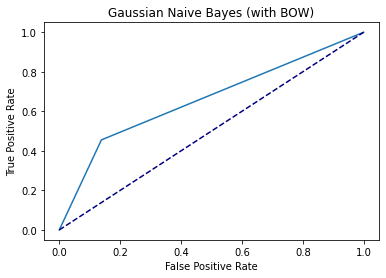

In [ ]:
model = GaussianNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Gaussian Naive Bayes (with BOW)', 'gaussian_nb_bow')          

Accuracy: 0.72012
F1 Score: 0.6909588799081312


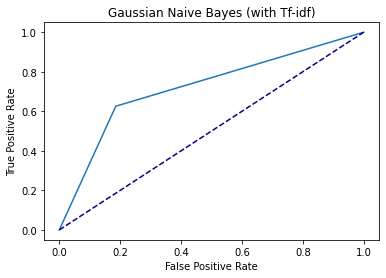

In [ ]:
model = GaussianNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Gaussian Naive Bayes (with Tf-idf)', 'gaussian_nb_tfidf')        

Accuracy: 0.834
F1 Score: 0.8271697484591036


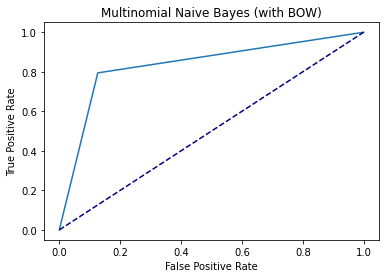

In [ ]:
model = MultinomialNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multinomial Naive Bayes (with BOW)', 'multinomial_nb_bow')

Accuracy: 0.839
F1 Score: 0.8337532526537524


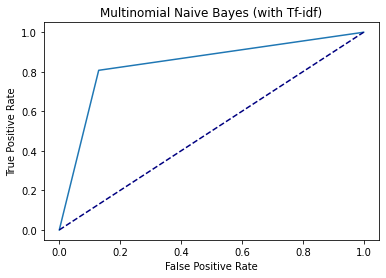

In [ ]:
model = MultinomialNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multinomial Naive Bayes (with Tf-idf)', 'multinomial_nb_tfidf')

In [ ]:
model = BernoulliNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with BOW)', 'bernoulli_nb_bow')

Accuracy: 0.83832
F1 Score: 0.8322682380280522


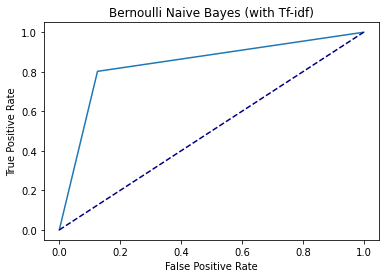

In [ ]:
model = BernoulliNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())et_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with Tf-idf)', 'bernoulli_nb_tfidf')

Accuracy: 0.66476
F1 Score: 0.6468630177390132


FileNotFoundError: ignored

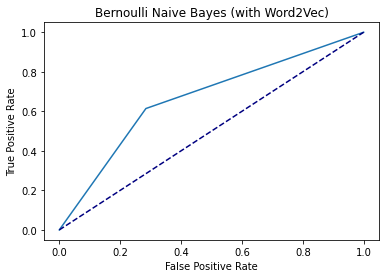

In [ ]:
model = BernoulliNB()
model.fit(train_vectors, train_sentiment)
preds = model.predict(test_vectors)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with Word2Vec)', 'bernoulli_nb_word2vec')

# **Get Results from models (Decision Trees and Random Forest)**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.7168
F1 Score: 0.7147001934235977


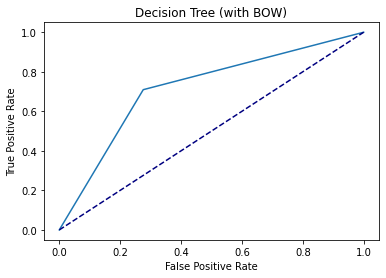

In [ ]:
model = DecisionTreeClassifier(random_state=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Decision Tree (with BOW)', 'decision_tree_bow')

Accuracy: 0.71064
F1 Score: 0.7073861338079442


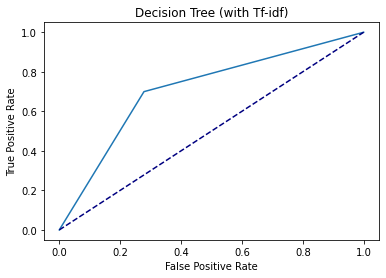

In [ ]:
model = DecisionTreeClassifier(random_state=4248)
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Decision Tree (with Tf-idf)', 'decision_tree_tfidf')

Accuracy: 0.84496
F1 Score: 0.8438985098670962


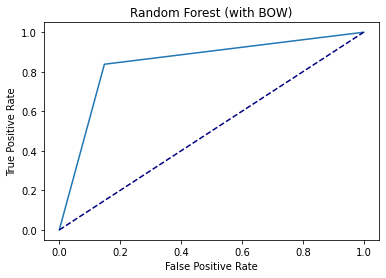

In [ ]:
model = RandomForestClassifier(random_state=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Random Forest (with BOW)', 'random_forest_bow')       

Accuracy: 0.8464
F1 Score: 0.8438389589263928


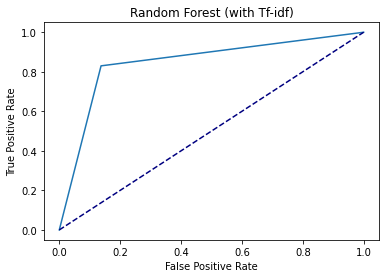

In [ ]:
model = RandomForestClassifier(random_state=4248)
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Random Forest (with Tf-idf)', 'random_forest_tfidf')        

# **Get Results from models (Linear)**

In [ ]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier, SGDOneClassSVM

Accuracy: 0.8522
F1 Score: 0.8505077477040093


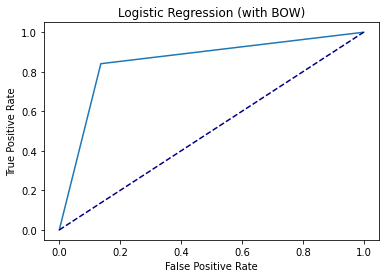

In [ ]:
model = LogisticRegression(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Logistic Regression (with BOW)', 'logistic_regression_bow')          

Accuracy: 0.88096
F1 Score: 0.881064663096475


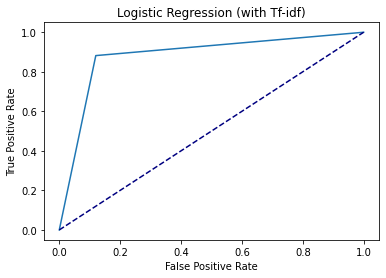

In [ ]:
model = LogisticRegression(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Logistic Regression (with Tf-idf)', 'logistic_regression_tfidf')          

Accuracy: 0.82972
F1 Score: 0.827014506887724


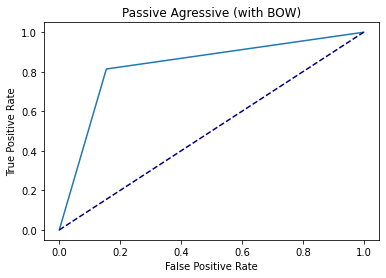

In [ ]:
model = PassiveAggressiveClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Passive Agressive (with BOW)', 'passive_aggressive_bow')  

Accuracy: 0.82396
F1 Score: 0.8202279318655283


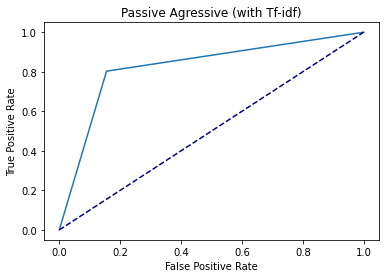

In [ ]:
model = PassiveAggressiveClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Passive Agressive (with Tf-idf)', 'passive_aggressive_tfidf') 

Accuracy: 0.82512
F1 Score: 0.818604265206207


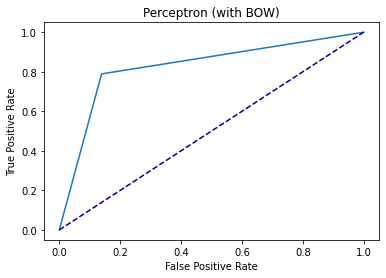

In [ ]:
model = Perceptron(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Perceptron (with BOW)', 'perceptron_bow')  

Accuracy: 0.828
F1 Score: 0.8286033163265306


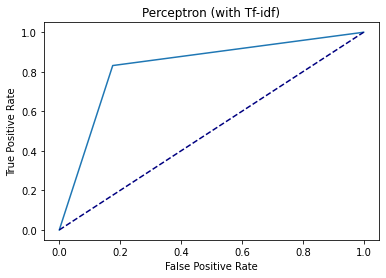

In [ ]:
model = Perceptron(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Perceptron (with Tf-idf)', 'perceptron_tfidf') 

Accuracy: 0.79128
F1 Score: 0.7886080051855453


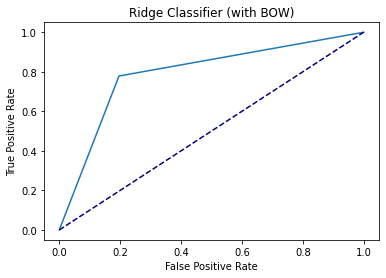

In [ ]:
model = RidgeClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Ridge Classifier (with BOW)', 'ridge_classifier_bow')  

Accuracy: 0.86232
F1 Score: 0.8612432476013867


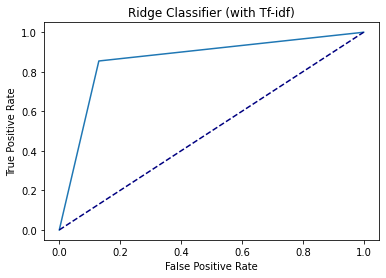

In [ ]:
model = RidgeClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Ridge Classifier (with Tf-idf)', 'ridge_classifier_tfidf') 

Accuracy: 0.83668
F1 Score: 0.8311623868006451


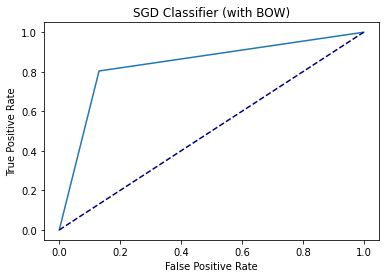

In [ ]:
model = SGDClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'SGD Classifier (with BOW)', 'sgd_classifier_bow')  

Accuracy: 0.87992
F1 Score: 0.8795441778348448


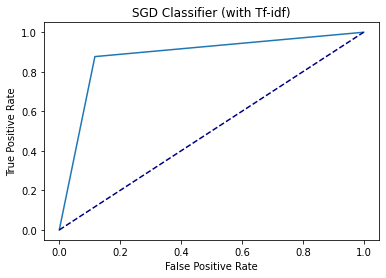

In [ ]:
model = SGDClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'SGD Classifier (with Tf-idf)', 'sgd_classifier_tfidf') 

# **Get Results from models (Simple NN)**

In [ ]:
from sklearn.neural_network import MLPClassifier

Accuracy: 0.84784
F1 Score: 0.8450635386119257


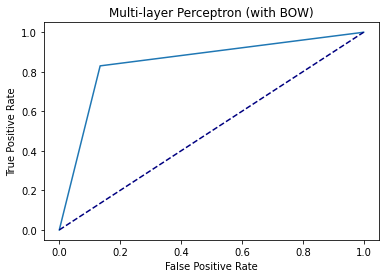

In [ ]:
model = MLPClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multi-layer Perceptron (with BOW)', 'multi_layer_perceptron_bow')          

Accuracy: 0.829
F1 Score: 0.8253747804419753


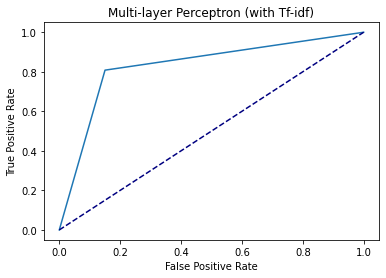

In [ ]:
model = MLPClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multi-layer Perceptron (with Tf-idf)', 'multi_layer_perceptron_tfidf')

In [ ]:
#tensorflow

# **Unsupervised Learning**

# **Artificial Movie Review Generation**